<div style="background-color:#009440; padding: 0px; background-size:cover; background-opacity:50%; border-radius:5px; height:300px">
    <div style="margin: 5px; padding: 10px;">
    <h1 style="color:#00000">Geophysical Data Acquisition and Analysis</h1>
    <h5 style="color:#C0C0C0">LMU, July 31, 2020</h5>
    <h4 style="color:rgba(0,0,0,0.6)">Alice Gabriel, Tobias Megies, Stephanie Wollherr, Sebastian Anger</h4>
    </div>
    <div style="float:right; margin: 20px; padding: 20px; background:rgba(255,255,255,0.7); width: 70%; height: 100px">
        <div style="position:relative; top:40%; transform: translateY(-50%)">
        <div style="font-size: x-large; font-weight:900; color:rgba(0,0,0,0.8); line-height:100%">P11 - Seismometer response & equation</div>
        </div>
    </div>
   
</div>

**Please, do not forget to execute Cell 1 first!**

In [2]:
# Cell 1: Preparation for programming
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')                  # do not show warnings
from scipy import interpolate, signal
from time import *
import numpy as np
from obspy import *
from obspy.core import read, UTCDateTime
from obspy.clients.fdsn import Client
from obspy.signal.invsim import paz_to_freq_resp
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import os
import glob
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['figure.facecolor'] = 'w'  # remove grey background

## Exercise 1: Effect of damping on seismometer response

In this exercise we will get acquainted with the seismometer response function. Here, you will find a program which shows the response of a damped oscillator, analogous to a simple mechanical seismometer. 
The **natural frequency** of the seismometer is **1 Hz**. 

Run cell 2. You will be prompted to choose values for the *frequency of forcing*, essentially the frequency of the ground motion, and for the *damping parameter* of the seismometer. 

a) Explain what happens for an undamped seismometer (h=0) for forcing frequencies ranging from 0.1Hz to 5Hz. (Note that the time axis changes!). 

b) For a forcing frequency of 5Hz, determine a suitable damping parameter. 

c) Do the same for a forcing frequency below 0.5Hz. What do you notice about the shape of the seismometer response?


Give frequency of forcing (e.g. f=1 Hz) : 1
Give damping parameter (e.g. h=0.5) : 5


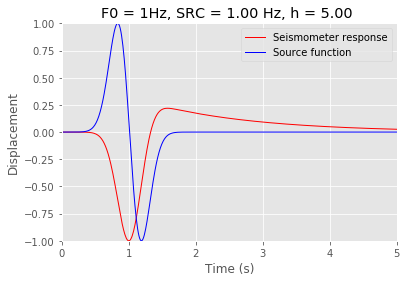

In [9]:
# Cell 2
# initialisations
f0 = 1.                                                  # eigenfrequency of seismometer 
w = 2. * np.pi * f0                                      # ... in radians
dt = .01                                                 # time increment for numerical scheme
fu0 = float(input('Give frequency of forcing (e.g. f=1 Hz) : '))  # central frequency of forcing
h = float(input('Give damping parameter (e.g. h=0.5) : '))        # damping constant

# initialize ground motion
p = 1. / fu0
nts = int(2. * p / dt)
uii = np.zeros(nts)
t0 = p / dt
a_ricker = 4. / p
for it in range(nts):
    t = (it - t0) * dt
    uii[it] = -2 * a_ricker * t * np.exp(-(a_ricker * t) ** 2)
# end initialize ground motion

nt = int(round(5. * 1. / fu0 / dt))                     # total number of time steps
src = np.zeros(nt)
src[0:len(uii)] = uii

# initial condition
eps = h * w                                             # damping factor
x = np.zeros(nt)
xnow = 0
xold = 0
x_vector = np.zeros(nt)

for i in range(nt):
    if i == 0:
        xold = xnow

    xnew = 1. / (1. / dt ** 2 + 2 * eps / (2 * dt)) * (-src[i] - w ** 2 * xnow +
           2 * eps / (2 * dt) * xold - (xold - 2 * xnow) / dt ** 2)
    xold = xnow
    xnow = xnew
    x[i] = xnow
    x_vector[i] = x[i]

#plot
plt.plot(np.dot((np.arange(1, nt+1)), dt), x_vector[0:nt] /
    np.max(np.abs(x[0:nt])), "r-", label="Seismometer response")
plt.plot(np.dot(np.arange(1, nt+1), dt), src[0:nt] / np.max(src[0:nt]), 
    'b-', label="Source function")
plt.title("F0 = 1Hz, SRC = %.2f Hz, h = %.2f " % (fu0, h))
plt.axis([0, nt*dt, -1, 1])
plt.xlabel("Time (s)")
plt.ylabel("Displacement")
plt.legend()
plt.show()


## Exercise 2: Seismometer characteristics

Recall the seismometer equation:

$\ddot{x}_r (t)+ 2\epsilon \dot{x}_r (t) + \omega_0^2 x_r (t) = -\ddot{u}_g$

where $2 \epsilon = \frac{D}{m} = 2h\omega_0$ is the damping factor, $\omega_0$ the natural frequency of the seismometer, $x_r$ the relative displacement of the mass within the seismometer, and $\ddot{u}_g$ the ground accelleration. 


a) What happens to $\ddot{x}_r$ (acceleration of the mass) when the mass moves very rapidly? What does that mean for $\dot{x}_r$ and $x_r$? What does the seismometer measure in that case?

b) Similarly, when the mass moves slowly: what happens to $\ddot{x}_r$ and $\dot{x}_r$? What do you measure? 

c) Can you interpret the two different shapes you saw in 1b) and 1c)? Hint: the output of the cell 3 may help!

### Auxiliary plot: derivatives of source function

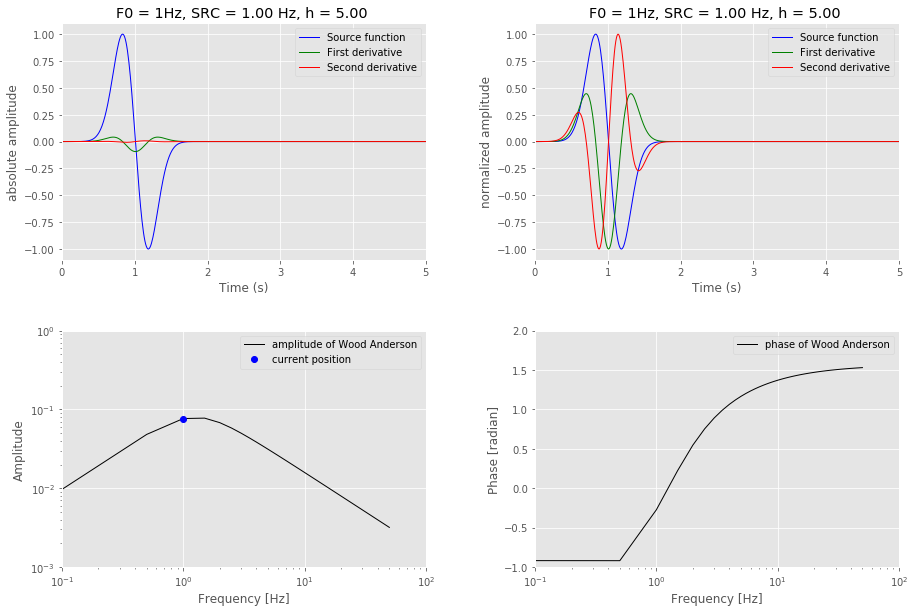

In [10]:
# Cell 3

time = np.dot(np.arange(1, nt+1), dt)
source = src[0:nt] / np.max(src[0:nt])
firstderiv =np.gradient(source)
secondderiv = np.gradient(firstderiv)

plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot(time, source, 'b', label='Source function')
plt.plot(time, firstderiv, 'g', label='First derivative' )
plt.plot(time, secondderiv, 'r', label='Second derivative')
plt.title("F0 = 1Hz, SRC = %.2f Hz, h = %.2f " % (fu0, h))
plt.axis([0, nt*dt, -1, 1])
plt.ylabel("absolute amplitude")
plt.ylim(-1.1,1.1)
plt.xlabel("Time (s)")
plt.legend()

plt.subplot(222)
plt.plot(time, source, 'b', label='Source function')
plt.plot(time, firstderiv/np.max(np.abs((firstderiv))), 'g', label='First derivative' )
plt.plot(time, secondderiv/np.max(np.abs((secondderiv))), 'r', label='Second derivative')
plt.title("F0 = 1Hz, SRC = %.2f Hz, h = %.2f " % (fu0, h))
plt.axis([0, nt*dt, -1, 1])
plt.ylabel("normalized amplitude")
plt.ylim(-1.1,1.1)
plt.xlabel("Time (s)")
plt.legend()

# preparation for subplot 3+4
poles = [-6.2832-4.7124j, -6.2832+4.7124j]
zeros = [0j]
gain = 1.0
h2, f = paz_to_freq_resp(poles, zeros, gain, dt, 200, freq=True)
ind = (f==fu0).nonzero()[0]
amp = abs(h2[ind])
# end preparation subplot 3+4

plt.subplot(223)
plt.loglog(f, abs(h2), 'k', label="amplitude of Wood Anderson")
plt.plot(fu0, amp,'bo', label="current position")
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.ylim(0.001, 1.)
plt.xlim(0.1,100)
plt.legend()

plt.subplot(224)
# take negative of imaginary part, see documentation of paz_to_freq_resp 
phase = np.unwrap(np.arctan2(-h2.imag, h2.real))
plt.semilogx(f, phase, 'k', label="phase of Wood Anderson")
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase [radian]')
plt.xlim(0.1,100)
plt.ylim(-1,2)
plt.legend()

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()